#### In semantic search:-    
* the input is a search query or a sentence describing the search intent    
* the output is a list of relevant documents or sentences that match the search query

#### In keyword extraction:-  
* the input is a document or a sentence     
* the output is a list of important keywords or key phrases that represent the main topics or themes of the text.


In [1]:
# !pip install summa
# !pip install gensim==3.4.0
# !pip install rake_nltk
# !pip install yake
# !pip install sentence-transformers

In [356]:
# nltk.download('reuters')
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import reuters
import nltk
import pandas as pd
from summa import keywords as summakeywords
from gensim.summarization import keywords as gensimkeywords
from rake_nltk import Rake
import yake
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from sklearn.metrics import confusion_matrix

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import plot_model



In [51]:
corpus_path = "reuters/reuters"
corpus = nltk.corpus.CategorizedPlaintextCorpusReader(corpus_path, r"^.*/[0-9]+", cat_pattern=r"([\w_]+)/.*",encoding='ISO-8859-1')
training_text = [corpus.raw(fileid) for category in corpus.categories() for fileid in corpus.fileids(category) if category == 'training']
testing_text = [corpus.raw(fileid) for category in corpus.categories() for fileid in corpus.fileids(category) if category == 'test']



In [52]:
print(len(training_text),len(testing_text))
print(training_text[0])

7769 3019
BAHIA COCOA REVIEW
  Showers continued throughout the week in
  the Bahia cocoa zone, alleviating the drought since early
  January and improving prospects for the coming temporao,
  although normal humidity levels have not been restored,
  Comissaria Smith said in its weekly review.
      The dry period means the temporao will be late this year.
      Arrivals for the week ended February 22 were 155,221 bags
  of 60 kilos making a cumulative total for the season of 5.93
  mln against 5.81 at the same stage last year. Again it seems
  that cocoa delivered earlier on consignment was included in the
  arrivals figures.
      Comissaria Smith said there is still some doubt as to how
  much old crop cocoa is still available as harvesting has
  practically come to an end. With total Bahia crop estimates
  around 6.4 mln bags and sales standing at almost 6.2 mln there
  are a few hundred thousand bags still in the hands of farmers,
  middlemen, exporters and processors.
      There

### I) Cosine similarity (Search)

#### 1- TFIDF

In [24]:
stop_words = set(nltk.corpus.stopwords.words('english'))
preprocessed_corpus = []
for doc in training_text:
    tokens = word_tokenize(doc.lower())
    filtered_tokens = [token for token in tokens if token not in stop_words]
    preprocessed_corpus.append(' '.join(filtered_tokens))


In [25]:
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(preprocessed_corpus)
feature_names = vectorizer.get_feature_names()


c:\Users\Cybral-1\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [26]:
def search(search_word, corpus, tfidf_matrix):
    query_vec = vectorizer.transform([search_word])
    sim_scores = cosine_similarity(query_vec, tfidf_matrix)
    results = []
    for idx, score in enumerate(sim_scores[0]):
        results.append((corpus[idx], score))
    sorted_results = sorted(results, key=lambda x: x[1], reverse=True)
    return sorted_results


In [28]:
search_sen = 'bank deposit'
results = search(search_sen, preprocessed_corpus, tfidf_matrix)

for result in results[:15]:
    print(result[0])
    print("="*50)


n.z . trading bank deposit growth rises slightly new zealand 's trading bank seasonally adjusted deposit growth rose 2.6 pct january compared rise 9.4 pct december , reserve bank said . year-on-year total deposits rose 30.6 pct compared 26.3 pct increase december year 34.5 pct rise year ago period , said weekly statistical release . total deposits rose 17.18 billion n.z . dlrs january compared 16.74 billion december 13.16 billion january 1986 .
taiwan issues certificates deposit central bank issued 5.65 billion dlrs worth certificates deposit ( cds ) , boosting cd issues far year 147.58 billion , bank spokesman told reuters . new cds , maturities six months , one year two years , carry interest rates ranging 4.07 pct 5.12 pct , said . issues intended help curb growth m-1b money supply grown result increasing foreign exchange reserves . reserves hit record 53 billion u.s. dlrs last month .
major swiss banks raise customer time deposit rates 1/4 point three pct - credit suisse major swis

#### 2-BERT

In [36]:
model_bert = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')


In [ ]:
train_dict = {'sen':training_text }
test_dict = {'sen':testing_text}

train_df = pd.DataFrame(train_dict)
test_df = pd.DataFrame(test_dict)

In [40]:
sentence_embeddings = model_bert.encode(train_df['sen'].values)

In [47]:
print(len(sentence_embeddings))

7769
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7769 entries, 0 to 7768
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   sen           7769 non-null   object
 1   keyword       7769 non-null   object
 2   cleaned_text  7769 non-null   object
dtypes: object(3)
memory usage: 182.2+ KB


In [ ]:
def BERT_search(df,word_search, n_results):
    search_embedding = model_bert.encode([word_search])[0]
    similarities = cosine_similarity([search_embedding], sentence_embeddings)[0]
    indices = np.argsort(similarities)[::-1][:n_results]
    return df.iloc[indices]['sen'].values.tolist()


In [ ]:
search_sen = 'computer terminal'
results = BERT_search(train_df,search_sen,10)
for sen in results:
    print(sen)
    print("="*50)

ADVANCED COMPUTER TECHNIQUES &lt;ACTP> YEAR NET
  Shr 41 cts vs 30 cts
      Net 700,000 vs 526,000
      Revs 15.2 mln vs 14.7 mln
  


BORG-WARNER TO SELL INDUSTRIAL PRODUCTS BUSINESS FOR ABOUT 240 MLN DLRS

  BORG-WARNER TO SELL INDUSTRIAL PRODUCTS BUSINESS FOR ABOUT 240 MLN DLRS
  


SCI &lt;SCIS> BUYS FORTUNE &lt;FSYS> COMPUTER ASSETS
  Fortune Systems Corp and SCI
  Systems Inc said they signed a letter of intent covering the
  purchase of Fortune's microcomputer business assets for an
  unspecified amount of cash.
      Fortune Systems makes a desktop computer systems.
  


TWA CONFIRMS OWNERSHIP OF 15 PCT OF USAIR GROUP

  TWA CONFIRMS OWNERSHIP OF 15 PCT OF USAIR GROUP
  


&lt;DOUGLAS COMPUTER INTERNATIONAL> YEAR END 1986
  Shr seven cts vs one ct
      Net 178,919 vs 34,429
      Revs 3,148,420 vs 1,912,438
  


&lt;DOUGLAS COMPUTER INTERNATIONAL> YEAR NET
  Shr seven cts vs one ct
      Net 178,919 vs 34,429
      Sales 3,148,420 vs 1,912,438
  


SOROS GROUP TELLS SEC IT M

### II) pre-trained Models 
- keywords

- 1- summa

In [8]:
for sen in training_text[0:5]:
    kw = summakeywords.keywords(sen)
    print(kw.split('\n')[:10])

['cocoa', 'sales', 'crop', 'bahia', 'comissaria', 'bean', 'week', 'weekly', 'weeks', 'april']
['price', 'lt', 'worldwide', 'product', 'common', 'terminal', 'terminals', 'said', 'sedio', 'shares']
['bank', 'deposit', 'deposits', 'year', 'pct', 'nz']
['viacom', 'national', 'said', 'lt', 'held', 'later']
['quarter', 'rogers', 'qtr', 'year', 'st', 'second']


- 2- rake

In [9]:
r = Rake()
for sen in training_text[0:5]:
    r.extract_keywords_from_text(sen)
    rake_keywords = r.get_ranked_phrases()
    print(rake_keywords[0:10])

['comissaria smith said spot bean prices rose', 'bahia cocoa review showers continued throughout', 'total bahia crop estimates around 6', '39 times new york dec', '25 times new york dec', '25 times new york sept', '25 times new york july', '27 times new york may', '27 times new york dec', '28 times new york sept']
['would help pay current operation costs', 'completes sale computer terminal systems inc said', 'computer terminal makes computer generated labels', 'computer terminal said sedio also', 'computer terminal also said', 'certain circumstances involving change', '125 dlrs per share', 'dot matrix impact technology', 'additional one mln shares', 'computer terminal systems']
['trading bank deposit growth rises slightly new zealand', 'trading bank seasonally adjusted deposit growth rose 2', 'year total deposits rose 30', 'total deposits rose', 'reserve bank said', 'weekly statistical release', 'year ago period', '3 pct increase', '5 pct rise', '6 pct compared']
['national amusements 

- 3-yake

In [10]:
kw_extractor = yake.KeywordExtractor(lan="en", top=10)
for sen in training_text[0:5]:
    yake_keywords = [kw[0] for kw in kw_extractor.extract_keywords(sen)]
    print(yake_keywords)

['Comissaria Smith', 'dlrs', 'York Dec', 'times New York', 'York', 'BAHIA COCOA REVIEW', 'York july', 'Smith', 'times', 'BAHIA']
['COMPUTER TERMINAL SYSTEMS', 'COMPUTER TERMINAL', 'COMPLETES SALE', 'TERMINAL SYSTEMS', 'TERMINAL', 'COMPUTER', 'Computer Terminal outstanding', 'common stock', 'Computer Terminal makes', 'Terminal makes computer']
['GROWTH RISES SLIGHTLY', 'Zealand trading bank', 'TRADING BANK DEPOSIT', 'BANK DEPOSIT GROWTH', 'TRADING BANK', 'DEPOSIT GROWTH', 'DEPOSIT GROWTH RISES', 'total deposits rose', 'pct', 'January compared']
['UPS VIACOM', 'BID', 'Arsenal Holdings', "Amusements' Arsenal Holdings", 'NATIONAL AMUSEMENTS', 'VIACOM', 'AMUSEMENTS AGAIN UPS', 'UPS', "National Amusements' Arsenal", 'NATIONAL']
['QTR NET', 'NET UP SIGNIFICANTLY', 'Rogers Corp', 'ROG', 'ROGERS', 'QTR', 'NET', 'SIGNIFICANTLY', 'quarter', 'earnings']


##### will continue with yake

In [ ]:
def get_keywords(sentences,n):
    kw_extractor = yake.KeywordExtractor(lan="en", top=n)
    
    keywords_lst = [] 
    for sen in sentences:
        keywords_lst.append([kw[0] for kw in kw_extractor.extract_keywords(sen)])
    if len(keywords_lst) == 1:
        return keywords_lst[0]
    else:
        return keywords_lst

In [12]:
keywords_lst_train = get_keywords(training_text,10)
keywords_lst_test = get_keywords(testing_text,10)

In [38]:
search_sen_train = get_keywords(training_text,1)
search_sen_test = get_keywords(testing_text,1)

In [ ]:
search_sen_test

In [13]:
print(len(keywords_lst_train) , len(keywords_lst_test))
print(len(training_text) , len(testing_text))

7769 3019
7769 3019


In [14]:
train_dict = {'sen':training_text , 'keyword':keywords_lst_train}
test_dict = {'sen':testing_text , 'keyword':keywords_lst_test}

train_df = pd.DataFrame(train_dict)
test_df = pd.DataFrame(test_dict)

In [15]:
train_df.iloc[0]

sen        BAHIA COCOA REVIEW\n  Showers continued throug...
keyword    [Comissaria Smith, dlrs, York Dec, times New Y...
Name: 0, dtype: object

### III) Training Model Using categories 

In [54]:
with open('reuters/reuters/cats.txt', 'r') as f:
    lines = f.read().splitlines()
lines[0]

'test/14826 trade'

In [55]:
train_files = {}
test_files = {}

In [65]:
for line in lines:
    file_and_categories = line.split(' ', maxsplit=1)
    file_name = file_and_categories[0]
    categories = file_and_categories[1].split(' ')
    if 'training' in file_name:
        train_files[file_name] = categories
    else:
        test_files[file_name] = categories


In [82]:
train_files['training/1']

['cocoa']

In [73]:
import os

training_data_path = 'reuters/reuters/training'
test_data_path = 'reuters/reuters/test'

for folder, files_dict in [(training_data_path, train_files), (test_data_path, test_files)]:
    for file_name in os.listdir(folder):
        file_path = os.path.join(folder, file_name)
        if file_name in files_dict:
            print(file_name)
            categories = files_dict[file_name]
            print(categories)
            print(files_dict)
    


In [101]:
def get_data(data_path,category_files):
    data= []
    for filename in os.listdir(data_path):
        with open(os.path.join(data_path, filename), "r",  encoding= 'unicode_escape') as f:
            file_data = f.read()
        folder_name = data_path.split('/')[2]
        category = category_files[folder_name+'/'+filename]
        
        data.append({"filename": filename, "sentence": file_data, "category": category})
    return data



In [232]:
train_data_path = 'reuters/reuters/training'
df_train = pd.DataFrame(get_data(train_data_path,train_files))
df_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7769 entries, 0 to 7768
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  7769 non-null   object
 1   sentence  7769 non-null   object
 2   category  7769 non-null   object
dtypes: object(3)
memory usage: 182.2+ KB


In [233]:
test_data_path = 'reuters/reuters/test'
df_test = pd.DataFrame(get_data(test_data_path,test_files))
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  3019 non-null   object
 1   sentence  3019 non-null   object
 2   category  3019 non-null   object
dtypes: object(3)
memory usage: 70.9+ KB


In [234]:
unique_categories = set()
for lst in df_train['category']:
    for value in lst:
        unique_categories.add(value)

len(unique_categories)

90

In [235]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7769 entries, 0 to 7768
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  7769 non-null   object
 1   sentence  7769 non-null   object
 2   category  7769 non-null   object
dtypes: object(3)
memory usage: 182.2+ KB


In [236]:
df_train = df_train.explode('category')
df_test = df_test.explode('category')


In [238]:
cat_count = df_train['category'].value_counts()
cat_count = dict(cat_count)
cat_count

{'earn': 2877,
 'acq': 1650,
 'money-fx': 538,
 'grain': 433,
 'crude': 389,
 'trade': 368,
 'interest': 347,
 'wheat': 212,
 'ship': 197,
 'corn': 182,
 'money-supply': 140,
 'dlr': 131,
 'sugar': 126,
 'oilseed': 124,
 'coffee': 111,
 'gnp': 101,
 'gold': 94,
 'veg-oil': 87,
 'soybean': 78,
 'livestock': 75,
 'nat-gas': 75,
 'bop': 75,
 'cpi': 69,
 'reserves': 55,
 'cocoa': 55,
 'carcass': 50,
 'copper': 47,
 'jobs': 46,
 'yen': 45,
 'ipi': 41,
 'iron-steel': 40,
 'cotton': 39,
 'gas': 37,
 'rubber': 37,
 'barley': 37,
 'alum': 35,
 'rice': 35,
 'meal-feed': 30,
 'palm-oil': 30,
 'sorghum': 24,
 'retail': 23,
 'silver': 21,
 'zinc': 21,
 'pet-chem': 20,
 'wpi': 19,
 'tin': 18,
 'rapeseed': 18,
 'housing': 16,
 'orange': 16,
 'strategic-metal': 16,
 'hog': 16,
 'lead': 15,
 'heat': 14,
 'soy-oil': 14,
 'soy-meal': 13,
 'fuel': 13,
 'lei': 12,
 'sunseed': 11,
 'dmk': 10,
 'lumber': 10,
 'income': 9,
 'tea': 9,
 'nickel': 8,
 'oat': 8,
 'l-cattle': 6,
 'groundnut': 5,
 'instal-debt': 5,

C:\Users\Cybral-1\AppData\Local\Temp/ipykernel_37564/616563471.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(categories, rotation=90)


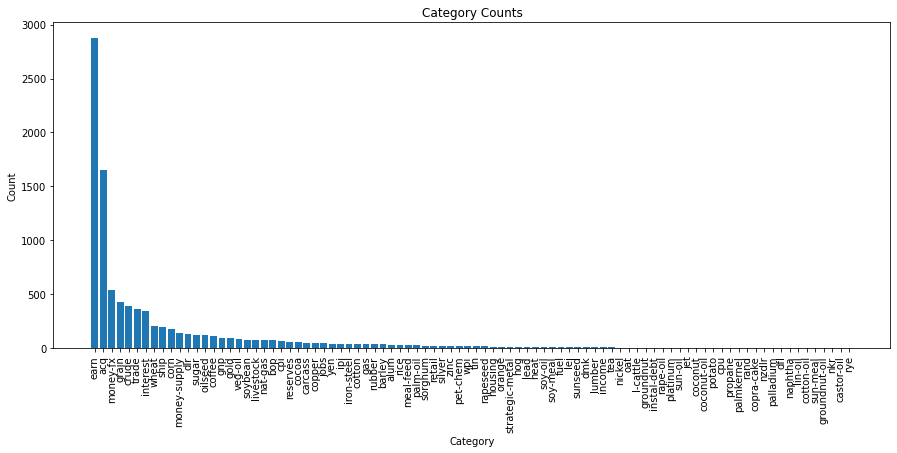

In [239]:
categories = list(cat_count.keys())
counts = list(cat_count.values())

fig, ax = plt.subplots(figsize=(15, 6))
ax.bar(categories, counts)

# Set the title and labels
ax.set_title("Category Counts")
ax.set_xlabel("Category")
ax.set_ylabel("Count")

# Rotate the x-axis tick labels vertically
ax.set_xticklabels(categories, rotation=90)

plt.show()

In [328]:
n = 100
new_category_counts = {k: v for k, v in cat_count.items() if v >= n}
not_category_counts = [v for v in cat_count.values() if v < n]

new_cat_df = pd.DataFrame(list(new_category_counts.items()), columns=['Category', 'Count'])


print(len(new_cat_df)/len(cat_count))
print(sum(not_category_counts) / sum(cat_count.values()))
print(n/new_cat_df.iloc[0]['Count'])
new_cat_df[0:5]

0.17777777777777778
0.1730829420970266
0.03475842891901286


,Category,Count
0,earn,2877
1,acq,1650
2,money-fx,538
3,grain,433
4,crude,389


In [241]:
new_cat = list(new_cat_df['Category'])
len(new_cat)

16

In [243]:
df_train = df_train[df_train['category'].isin(new_cat)]
df_test = df_test[df_test['category'].isin(new_cat)]

In [244]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3012 entries, 0 to 3016
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  3012 non-null   object
 1   sentence  3012 non-null   object
 2   category  3012 non-null   object
dtypes: object(3)
memory usage: 94.1+ KB


In [245]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7926 entries, 1 to 7768
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  7926 non-null   object
 1   sentence  7926 non-null   object
 2   category  7926 non-null   object
dtypes: object(3)
memory usage: 247.7+ KB


In [246]:
df_train.head()

,filename,sentence,category
1,10,COMPUTER TERMINAL SYSTEMS &lt;CPML> COMPLETES ...,acq
2,100,N.Z. TRADING BANK DEPOSIT GROWTH RISES SLIGHTL...,money-supply
3,1000,NATIONAL AMUSEMENTS AGAIN UPS VIACOM &lt;VIA> ...,acq
4,10000,ROGERS &lt;ROG> SEES 1ST QTR NET UP SIGNIFICAN...,earn
5,10002,ISLAND TELEPHONE SHARE SPLIT APPROVED\n &lt;I...,earn


In [251]:
# Load a pre-trained transformer model
model_bert = SentenceTransformer('bert-base-nli-mean-tokens')


In [252]:
train_embeddings = model_bert.encode(df_train['sentence'].tolist())
test_embeddings = model_bert.encode(df_test['sentence'].tolist())

In [257]:
df_train['category'].nunique()

16

In [260]:
df_train['category']

1                acq
2       money-supply
3                acq
4               earn
5               earn
            ...     
7764        money-fx
7765            earn
7766            earn
7767            earn
7768            earn
Name: category, Length: 7926, dtype: object

In [263]:
label_encoder = LabelEncoder()

labels_train_encoded = label_encoder.fit_transform(df_train['category'])
num_categories = len(label_encoder.classes_)

labels_train = np.zeros((len(df_train), num_categories))

for i, category_idx in enumerate(labels_train_encoded):
    labels_train[i, category_idx] = 1
    
print(len(labels_train) , labels_train[0])

7926 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [269]:
labels_test_encoded = label_encoder.transform(df_test['category'])
labels_test = np.zeros((len(df_test), num_categories))

for i, category_idx in enumerate(labels_test_encoded):
    labels_test[i, category_idx] = 1

print(len(labels_test) , labels_test[0])

3012 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


In [270]:
print(len(labels_train) ,len(train_embeddings))
print(len(labels_test) ,len(test_embeddings))

7926 7926
3012 3012


In [292]:
x_valid, x_test, y_valid, y_test = train_test_split(test_embeddings, labels_test, test_size=0.4, random_state=42,shuffle=True)
print(len(x_valid),len(x_test))

1807 1205


In [293]:
input_shape = (train_embeddings.shape[1],)

inputs = Input(shape=input_shape)
x = Dense(256, activation='relu')(inputs)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(16, activation='softmax')(x)
model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=Adam(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

num_epochs = 30
batch_size = 32
history = model.fit(train_embeddings, labels_train, epochs=num_epochs, batch_size=batch_size,validation_data=(x_valid, y_valid))



Epoch 1/30
248/248 [==============================] - 3s 7ms/step - loss: 1.0842 - accuracy: 0.6509 - val_loss: 0.6226 - val_accuracy: 0.7786
Epoch 2/30
248/248 [==============================] - 3s 10ms/step - loss: 0.7418 - accuracy: 0.7398 - val_loss: 0.5889 - val_accuracy: 0.7997
Epoch 3/30
248/248 [==============================] - 2s 6ms/step - loss: 0.6535 - accuracy: 0.7662 - val_loss: 0.5397 - val_accuracy: 0.8035
Epoch 4/30
248/248 [==============================] - 2s 6ms/step - loss: 0.5940 - accuracy: 0.7830 - val_loss: 0.5386 - val_accuracy: 0.8024
Epoch 5/30
248/248 [==============================] - 1s 6ms/step - loss: 0.5687 - accuracy: 0.7930 - val_loss: 0.5029 - val_accuracy: 0.8196
Epoch 6/30
248/248 [==============================] - 2s 8ms/step - loss: 0.5474 - accuracy: 0.7936 - val_loss: 0.5047 - val_accuracy: 0.8157
Epoch 7/30
248/248 [==============================] - 2s 7ms/step - loss: 0.5202 - accuracy: 0.8058 - val_loss: 0.5242 - val_accuracy: 0.8008
Epoch

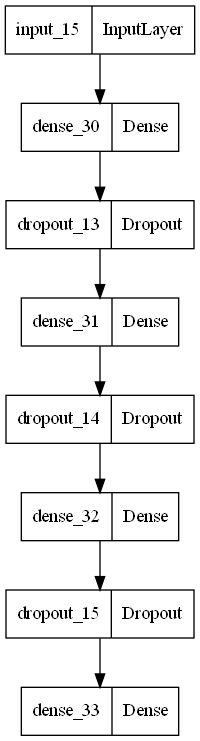

In [357]:
plot_model(model)

In [294]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

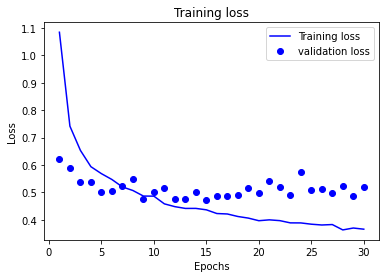

In [295]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='validation loss')

plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

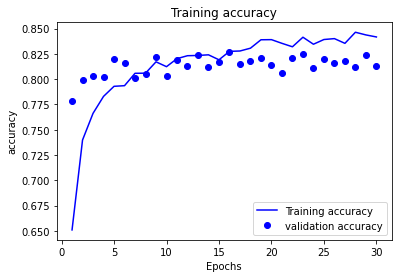

In [296]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'bo', label='validation accuracy')

plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()

plt.show()

#### Early Stopping in epoch 15

In [297]:
def predict(x,model):
    p = model.predict(np.array([x]))
    p = np.argmax(p, axis=-1)
    y_predict = p[0]
    return y_predict  

In [354]:
y_pred_test = []
for x in x_test:
    y_pred_test.append(predict(x,model))

1/1 [==============================] - 1s 512ms/step


In [353]:
y_true_test = []
for y in y_test:
    y_true_test.append(np.argmax(y))

In [337]:
y_true_train = []
for y in labels_train:
    y_true_train.append(np.argmax(y))

In [339]:
y_pred_train = []
for x in train_embeddings:
    y_pred_train.append(predict(x,model))

1/1 [==============================] - 0s 104ms/step


In [338]:
y_true_valid = []
for y in y_valid:
    y_true_valid.append(np.argmax(y))

In [340]:
y_pred_valid = []
for x in x_valid:
    y_pred_valid.append(predict(x,model))

1/1 [==============================] - 0s 113ms/step


In [312]:
cm = confusion_matrix(y_true_test, y_pred_test)
cm_df = pd.DataFrame(cm)
pd.set_option('display.max_columns',9999)
pd.set_option('display.width',9999)
cm_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,263,0,0,4,0,5,0,0,1,0,0,0,0,0,0,0
1,0,5,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,16,0,0,0,0,0,0,1,0
3,4,0,0,65,0,1,0,0,0,0,0,0,5,0,3,0
4,0,0,0,0,10,0,0,0,4,6,0,0,0,0,0,0
5,8,0,0,0,0,423,0,0,0,0,0,0,0,0,0,0
6,0,0,0,1,0,0,6,0,2,0,0,0,0,0,4,0
7,0,0,0,0,0,0,1,45,0,0,0,2,1,0,3,12
8,1,0,0,1,0,0,0,0,41,14,3,0,0,0,1,0
9,0,0,0,1,4,0,0,0,20,44,1,0,0,0,4,0


In [355]:
from sklearn.metrics import accuracy_score
print("train acc = " + str(accuracy_score(y_true_train, y_pred_train)))
print("Valid acc = " + str(accuracy_score(y_true_valid, y_pred_valid)))
print("test acc = " + str(accuracy_score(y_true_test, y_pred_test)))

train acc = 0.8544032298763563
Valid acc = 0.813503043718871
test acc = 0.8365145228215768


In [315]:
f1_test = f1_score(y_true_test, y_pred_test,average='micro')
f1_test

0.8365145228215768

In [316]:
# weight of each class (no. of samples)
f1_test2 = f1_score(y_true_test, y_pred_test,average='weighted')
f1_test2

0.8299597051855693

### IV) TensorFlow

In [191]:
train_embeddings_tensor = torch.tensor(train_embeddings)
test_embeddings_tensor = torch.tensor(test_embeddings)



In [192]:
train_labels_tensor = torch.tensor(labels_train, dtype=torch.float32)
test_labels_tensor = torch.tensor(labels_test, dtype=torch.float32)


In [193]:
train_dataset = TensorDataset(train_embeddings_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_embeddings_tensor, test_labels_tensor)


In [194]:

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [195]:
class SemanticSearchModel(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, output_size)
        
    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [197]:
model = SemanticSearchModel(input_size=768, output_size=len(df_train['category']))

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [198]:
num_epochs = 5
for epoch in range(num_epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))


Epoch [1/5], Loss: 0.0000
Epoch [2/5], Loss: 0.0001
Epoch [3/5], Loss: 0.0000
Epoch [4/5], Loss: 0.0001
Epoch [5/5], Loss: 0.0000
